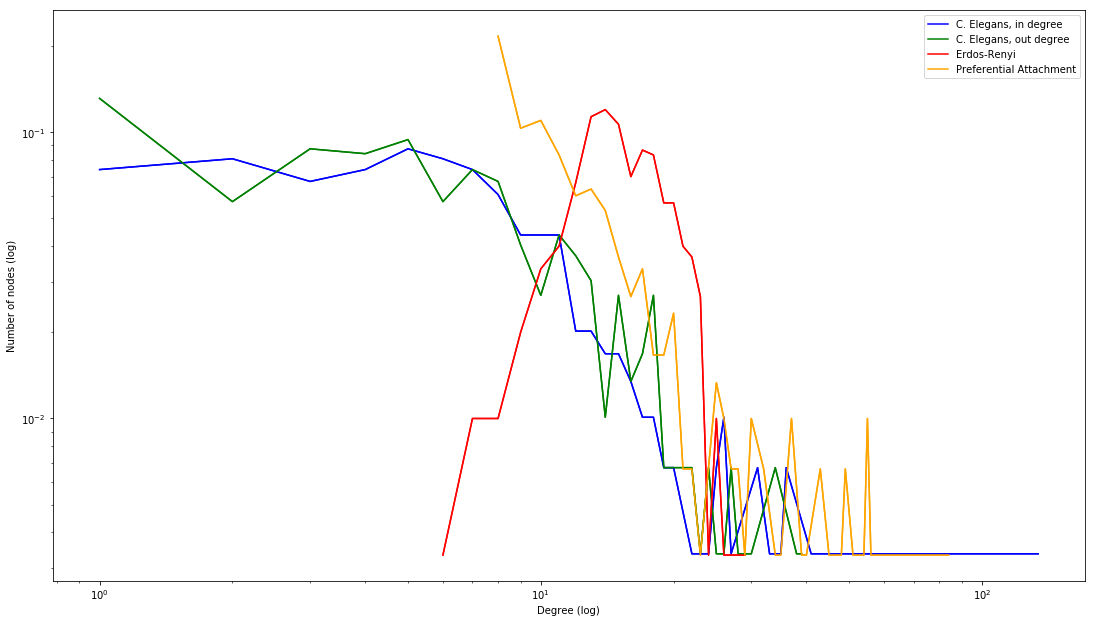

In [5]:
# %load compute_celegans_stats
import snap
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

def compute_HITS(Graph):
    '''
    :param Graph: the graph to compute HITS on
    :return:
        1. list of tuple (hub_score, node_id) in descending order
        2. list of tuple (authority_score, node_id) in descending order
    '''
    NIdHubH = snap.TIntFltH()   # placeholder for hub
    NIdAuthH = snap.TIntFltH()  # placeholder for authority
    snap.GetHits(Graph, NIdHubH, NIdAuthH)

    listAuth = []
    listHub = []

    for item in NIdHubH:
        listHub.append((NIdHubH[item], item))
    for item in NIdAuthH:
        listAuth.append((NIdAuthH[item], item))

    return sorted(listHub)[::-1], sorted(listAuth)[::-1]

def compute_pagerank(Graph):
    '''
    :param Graph: the graph to compute pagerank on
    :return: a list of tuple (pagerank_score, node_id) in descending order
    '''
    PRankH = snap.TIntFltH()
    snap.GetPageRank(Graph, PRankH)
    listPageRank = []
    for item in PRankH:
        listPageRank.append((PRankH[item], item))

    return sorted(listPageRank)[::-1]


def get_clustering_coefficient(Graph):
    return snap.GetClustCf (Graph, -1)

def get_in_degree_distribution(Graph):
    DegToCntV = snap.TIntPrV()
    snap.GetInDegCnt(Graph, DegToCntV)
    num_node = Graph.GetNodes()
    XI, YI = [], []
    for item in DegToCntV:
        if item.GetVal1() == 0 or item.GetVal2() == 0:
            continue
        XI.append(item.GetVal1())
        YI.append(item.GetVal2() * 1.0 / num_node)
    return XI, YI

def get_out_degree_distribution(Graph):
    DegToCntV = snap.TIntPrV()
    snap.GetOutDegCnt(Graph, DegToCntV)
    num_node = Graph.GetNodes()
    XO, YO = [], []
    for item in DegToCntV:
        if item.GetVal1() == 0 or item.GetVal2() == 0:
            continue
        XO.append(item.GetVal1())
        YO.append(item.GetVal2() * 1.0 / num_node)
    return XO, YO
    
def draw_degree_distribution(Graph, Graph1, Graph2, logAxis = True):
    XI, YI = get_in_degree_distribution(Graph)
    XO, YO = get_out_degree_distribution(Graph)
    X1, Y1 = get_out_degree_distribution(Graph1) # Both are undirected graphs, so can use either in-degree or out-degree
    X2, Y2 = get_out_degree_distribution(Graph2)
    
    l0, = plt.loglog(XI, YI, '-', color = 'blue', label = 'Degree Distribution (log)')
    l1, = plt.loglog(XO, YO, '-', color = 'green', label = 'Degree Distribution (log)')
    l2, = plt.loglog(X1, Y1, '-', color = 'red', label = 'Degree Distribution (log)')
    l3, = plt.loglog(X2, Y2, '-', color = 'orange', label = 'Degree Distribution (log)')
    plt.legend([l0, l1, l2, l3], ['C. Elegans, in degree', 'C. Elegans, out degree', 'Erdos-Renyi', 'Preferential Attachment'])
    plt.xlabel('Degree (log)')
    plt.ylabel('Number of nodes (log)')
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    # fig.savefig('test2png.png', dpi=100)
    plt.show()


def fit_deg_dist(Graph):

    def func(x, a, b):
        return a * np.exp(-b * x)
    DegToCntV = snap.TIntPrV()

    X, Y = get_in_degree_distribution(Graph)

    plt.subplot(2, 1, 1)
    X = np.array(X)
    Y = np.array(Y)
    popt, pcov = curve_fit(func, X, Y)
    a, b = popt
    l0, = plt.plot(X, Y, color = 'olive', label = 'Degree Distribution')
    l1, = plt.plot(X, [func(x, a, b) for x in X])
    plt.legend([l0, l1], ['C. Elegans, in degree', 'Fitted a*exp(-b*x) curve'])
    plt.xlabel('Degree')
    plt.ylabel('Number of nodes')
    
    X, Y = get_out_degree_distribution(Graph)

    plt.subplot(2, 1, 2)
    X = np.array(X)
    Y = np.array(Y)
    popt, pcov = curve_fit(func, X, Y)
    a, b = popt
    l0, = plt.plot(X, Y, color = 'olive', label = 'Degree Distribution')
    l1, = plt.plot(X, [func(x, a, b) for x in X])
    plt.legend([l0, l1], ['C. Elegans, out degree', 'Fitted a*exp(-b*x) curve'])
    plt.xlabel('Degree')
    plt.ylabel('Number of nodes')
    
    plt.show()

def get_diameter(Graph):
    NTestNodes = 302
    return snap.GetBfsFullDiam(Graph, NTestNodes, True)

Graph = snap.LoadEdgeList(snap.PNGraph, "../data/celegans_n306.txt", 0, 1)
Graph1 = snap.LoadEdgeList(snap.PUNGraph, "../data/Erdos-Renyi.txt", 0, 1)
Graph2 = snap.LoadEdgeList(snap.PUNGraph, "../data/PrefAttach.txt", 0, 1)

draw_degree_distribution(Graph, Graph1, Graph2)

# fit_deg_dist(Graph)


# print get_clustering_coefficient(Graph)

# HITS = compute_HITS(Graph)
# print HITS[0][0], HITS[1][0]
# print compute_pagerank(Graph)[0]



In [25]:
#For large degree nodes, do they connect to other large degree nodes or do they connect to small degree nodes?
#Define small deg := nodes with degree 1; large degree: nodes with degree > 30
OutDegV = snap.TIntPrV()
snap.GetNodeOutDegV(Graph, OutDegV)
smallOutDegNodes = []
medOutDegNodes = []
largeOutDegNodes = []

for item in OutDegV:
    if item.GetVal2() <= 1:
        smallOutDegNodes.append(item.GetVal1())
    elif item.GetVal2() > 30:
        largeOutDegNodes.append(item.GetVal1())
    else:
        medOutDegNodes.append(item.GetVal1())
        
InDegV = snap.TIntPrV()
snap.GetNodeInDegV(Graph, InDegV)
smallInDegNodes = []
medInDegNodes = []
largeInDegNodes = []

# 55 communities via Girvan-Newman
community_detection_results = [[1, 2, 56, 119, 158, 159], [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 43, 44, 53, 70, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 107, 108, 118, 120, 121, 122, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 139, 140, 143, 160, 161, 171, 201, 202], [39], [42], [45, 69, 85], [46], [47, 48, 52, 61, 62, 67, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 110, 111, 112, 115, 116, 117, 141, 142, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 162, 163, 164, 165, 166, 167, 168, 169, 170, 172, 173, 174, 177, 178, 185, 186, 187, 188, 189, 192, 193, 194, 195, 196, 198, 199, 200, 203, 204, 205, 206, 207, 208, 210, 212, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 234, 235, 236, 237, 240, 241, 242, 245, 246, 247, 249, 250, 251, 252, 253, 254, 255, 261, 262, 268, 269, 270, 271, 272, 275, 276, 277, 278, 279, 280, 303, 305, 306], [49, 50, 51, 54, 55, 57, 58, 59, 63, 64, 83, 87, 88, 109, 113, 114], [60, 86], [65], [66], [68], [84], [105], [106], [123], [127, 137, 138, 213, 214], [175], [176], [179, 180, 183], [181, 182], [184], [190], [191], [197], [209], [211], [231], [232, 233, 238, 281], [239], [243, 282], [244, 274], [248], [256], [257], [258], [259], [260], [263], [264], [265], [266], [267], [273], [291], [292], [293], [294], [295], [296], [297], [298], [299], [300], [301], [302]]
#community_detection_deg = [[] for c in community_detection_results]

for item in InDegV:
    if item.GetVal2() <= 1:
        smallInDegNodes.append(item.GetVal1())
    elif item.GetVal2() > 20:
        largeInDegNodes.append(item.GetVal1())
    else:
        medInDegNodes.append(item.GetVal1())

NodeToInDeg = {} # mapping node id to in-degree
for item in InDegV:
    NodeToInDeg[item.GetVal1()] = item.GetVal2()
    
NodeToOutDeg = {} # mapping node id to in-degree
for item in OutDegV:
    NodeToOutDeg[item.GetVal1()] = item.GetVal2()

community_detection_deg = []    
for community in community_detection_results:
    deg_list_temp = []
    for id in community:
        deg_list_temp.append((id, NodeToInDeg[id], NodeToOutDeg[id]))
    community_detection_deg.append(str(deg_list_temp))

print '\n\n'.join(community_detection_deg)

# print len(smallInDegNodes), len(medInDegNodes), len(largeInDegNodes)
# print len(smallOutDegNodes), len(medOutDegNodes), len(largeOutDegNodes)

[(1, 2, 9), (2, 8, 7), (56, 11, 10), (119, 11, 11), (158, 10, 12), (159, 8, 9)]

[(3, 4, 12), (4, 5, 15), (5, 5, 5), (6, 5, 3), (7, 6, 9), (8, 6, 11), (9, 6, 5), (10, 6, 5), (11, 0, 8), (12, 0, 9), (13, 1, 12), (14, 3, 11), (15, 1, 10), (16, 3, 10), (17, 4, 15), (18, 8, 17), (19, 5, 3), (20, 4, 5), (21, 6, 7), (22, 5, 8), (23, 14, 1), (24, 13, 1), (25, 5, 3), (26, 9, 1), (27, 13, 1), (28, 11, 2), (29, 3, 5), (30, 3, 6), (31, 2, 5), (32, 3, 6), (33, 2, 8), (34, 2, 12), (35, 2, 6), (36, 2, 7), (37, 1, 11), (38, 2, 11), (40, 7, 18), (41, 7, 18), (43, 5, 7), (44, 7, 11), (53, 0, 8), (70, 5, 6), (89, 26, 14), (90, 27, 17), (91, 17, 9), (92, 14, 6), (93, 9, 10), (94, 13, 8), (95, 15, 14), (96, 18, 17), (97, 5, 9), (98, 5, 11), (99, 18, 7), (100, 20, 6), (101, 15, 4), (102, 14, 3), (103, 5, 6), (104, 6, 4), (107, 10, 7), (108, 13, 6), (118, 13, 24), (120, 7, 22), (121, 19, 2), (122, 16, 2), (124, 6, 5), (125, 5, 2), (126, 7, 3), (128, 11, 7), (129, 5, 1), (130, 3, 1), (131, 5, 1), (132, 5, 1)

In [12]:
# %load community_detection
import networkx as nx
import itertools
from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms.efficiency import global_efficiency

def read_graph_file(file_path):
    edge_list = []
    f = open(file_path)
    line = f.readline()
    while line:
        new_edge = line.split()
#         print new_edge[0]
        new_edge[0] = int(new_edge[0])
        new_edge[1] = int(new_edge[1])
        # new_edge[2] = int(new_edge[2])
        edge_list.append(tuple(new_edge))
        line = f.readline()
    return edge_list

def run_girvan_newman(Graph):
    comp = girvan_newman(Graph)
    k = 55
#     limited = itertools.takewhile(lambda c: len(c) <= k, comp)
#     for communities in limited:
#         print(tuple(sorted(c) for c in communities))
    for communities in itertools.islice(comp, k):
        print(tuple(sorted(c) for c in communities)) 


G_elegans = nx.DiGraph()
G_elegans.add_weighted_edges_from(read_graph_file("../data/celegans_n306.txt"))
run_girvan_newman(G_elegans)


G_elegans = nx.Graph()
G_elegans.add_edges_from(read_graph_file("../data/Erdos-Renyi.txt"))
# print global_efficiency(G_elegans)

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 2

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 2

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 2

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 

([1, 2, 39, 42, 46, 47, 48, 52, 56, 60, 61, 62, 66, 67, 68, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 86, 110, 111, 112, 115, 116, 117, 119, 123, 141, 142, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 162, 163, 164, 165, 166, 167, 168, 169, 170, 172, 173, 174, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 192, 193, 194, 195, 196, 197, 198, 199, 200, 203, 204, 205, 206, 207, 208, 209, 210, 212, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 258, 260, 261, 262, 263, 264, 265, 266, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 303, 305, 306], [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 43, 44, 53, 70, 89, 90, 91, 92, 93, 94, 95, 96,

([1, 2, 39, 42, 47, 48, 52, 56, 61, 62, 66, 67, 68, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 110, 111, 112, 115, 116, 117, 119, 123, 141, 142, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 162, 163, 164, 165, 166, 167, 168, 169, 170, 172, 173, 174, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 192, 193, 194, 195, 196, 197, 198, 199, 200, 203, 204, 205, 206, 207, 208, 209, 210, 212, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 234, 235, 236, 237, 239, 240, 241, 242, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 258, 260, 261, 262, 263, 264, 265, 266, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 303, 305, 306], [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 43, 44, 53, 70, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108

([1, 2, 56, 119, 158, 159], [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 43, 44, 53, 70, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 118, 120, 121, 122, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 139, 140, 143, 160, 161, 171, 201, 202], [39], [42, 47, 48, 52, 61, 62, 67, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 110, 111, 112, 115, 116, 117, 123, 141, 142, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 162, 163, 164, 165, 166, 167, 168, 169, 170, 172, 173, 174, 177, 178, 179, 180, 183, 184, 185, 186, 187, 188, 189, 190, 192, 193, 194, 195, 196, 197, 198, 199, 200, 203, 204, 205, 206, 207, 208, 209, 210, 212, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 234, 235, 236, 237, 239, 240, 241, 242, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 260, 261, 26

([1, 2, 56, 119, 158, 159], [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 43, 44, 53, 70, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 118, 120, 121, 122, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 139, 140, 143, 160, 161, 171, 201, 202], [39], [42], [45, 69, 85], [46], [47, 48, 52, 61, 62, 67, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 110, 111, 112, 115, 116, 117, 123, 141, 142, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 162, 163, 164, 165, 166, 167, 168, 169, 170, 172, 173, 174, 177, 178, 179, 180, 183, 185, 186, 187, 188, 189, 192, 193, 194, 195, 196, 197, 198, 199, 200, 203, 204, 205, 206, 207, 208, 210, 212, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 234, 235, 236, 237, 239, 240, 241, 242, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 260, 261, 

([1, 2, 56, 119, 158, 159], [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 43, 44, 53, 70, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 107, 108, 118, 120, 121, 122, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 139, 140, 143, 160, 161, 171, 201, 202], [39], [42], [45, 69, 85], [46], [47, 48, 52, 61, 62, 67, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 110, 111, 112, 115, 116, 117, 141, 142, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 162, 163, 164, 165, 166, 167, 168, 169, 170, 172, 173, 174, 177, 178, 185, 186, 187, 188, 189, 192, 193, 194, 195, 196, 197, 198, 199, 200, 203, 204, 205, 206, 207, 208, 210, 212, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 234, 235, 236, 237, 240, 241, 242, 244, 245, 246, 247, 249, 250, 251, 252, 253, 254, 255, 261, 262, 263, 264, 265, 268, 269, 270, 271, 

([1, 2, 56, 119, 158, 159], [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 43, 44, 53, 70, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 107, 108, 118, 120, 121, 122, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 139, 140, 143, 160, 161, 171, 201, 202], [39], [42], [45, 69, 85], [46], [47, 48, 52, 61, 62, 67, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 110, 111, 112, 115, 116, 117, 141, 142, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 162, 163, 164, 165, 166, 167, 168, 169, 170, 172, 173, 174, 177, 178, 185, 186, 187, 188, 189, 192, 193, 194, 195, 196, 198, 199, 200, 203, 204, 205, 206, 207, 208, 210, 212, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 234, 235, 236, 237, 240, 241, 242, 245, 246, 247, 249, 250, 251, 252, 253, 254, 255, 261, 262, 268, 269, 270, 271, 272, 275, 276, 277, 278, 

In [14]:
a=set([23, 131, 24, 132, 303, 305, 27, 26, 133, 134, 105, 106, 129, 130, 162, 164, 163, 306, 275, 277, 278, 175, 176, 274, 194, 211, 282, 279, 280, 281, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302])

In [15]:
b=set([37, 11, 12, 13, 15, 105, 39, 53, 63, 64, 112, 83, 214, 213, 151, 184, 171, 185, 175, 176, 181, 182, 190, 191, 209, 210, 211, 212, 231, 232, 233, 243, 257, 259, 267, 268, 273, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302])

In [19]:
list(a.intersection(b))

[291,
 292,
 293,
 294,
 295,
 296,
 105,
 298,
 299,
 300,
 301,
 302,
 175,
 176,
 211,
 297]